In [16]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02a_machine_perception.ipynb"
_nb_title = "Flowers Image Classification using a linear model"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Flowers Image Classification using a linear model&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F02_ml_models%2F02a_machine_perception.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F02_ml_models%2F02a_machine_perception.ipynb">
    <img src="https://cloud.google.com/images/press/logo-cloud.png" width="100"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02a_machine_perception.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02a_machine_perception.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/02_ml_models/02a_machine_perception.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Flowers Image Classification using a linear model

We'll be using a creative-commons licensed 
[flower photo dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) 
of 3670 images falling into 5 categories:
<pre>
'daisy', 'roses', 'dandelion', 'sunflowers', and 'tulips'
</pre>
We have already prepared these images to be stored
in Google Cloud Storage in a public bucket:
<pre>
gs://cloud-ml-data/img/flower_photos/.
</pre>

The images are randomly split
into a training set with 90% data and a
test set with 10% data listed in CSV files:

Training set: [train_set.csv](https://storage.cloud.google.com/cloud-ml-data/img/flower_photos/train_set.csv)
Evaluation set: [eval_set.csv](https://storage.cloud.google.com/cloud-ml-data/img/flower_photos/eval_set.csv)


## Enable GPU

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


## Let's examine these images

Let's see the first five lines of the train_set.csv
You'll notice that each line consists of a JPEG filename
and the type of flower it is.

In [ ]:
!gsutil cat gs://cloud-ml-data/img/flower_photos/train_set.csv | head -20

gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://cloud-ml-data/img/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://cloud-ml-data/img/flower_photos/sunflowers/4933229095_f7e4218b28.jpg,sunflowers
gs://cloud-ml-data/img/flower_photos/daisy/14523675369_97c31d0b5b.jpg,daisy
gs://cloud-ml-data/img/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg,sunflowers
gs://cloud-ml-data/img/flower

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://cloud-ml-data/img/flower_photos/*"),
                 "gs://cloud-ml-data/img/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


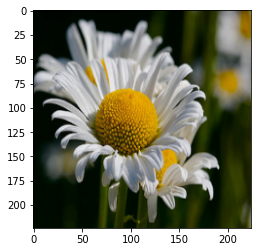

In [ ]:
# Try reading and displaying one of the files
def show_image(filename):
  img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
  plt.imshow((img.numpy()));

show_image(
    "gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

gs://cloud-ml-data/img/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://cloud-ml-data/img/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://cloud-ml-data/img/flower_photos/tulips/10094731133_94a942463c.jpg
gs://cloud-ml-data/img/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://cloud-ml-data/img/flower_photos/tulips/10163955604_ae0b830975_n.jpg


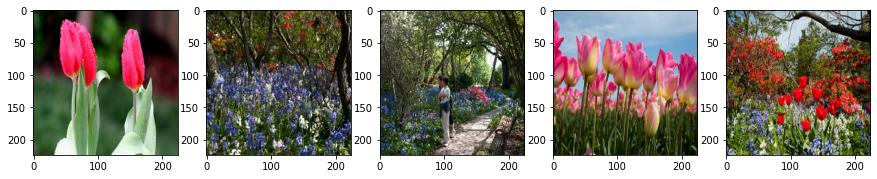

In [ ]:
# notice that the file name has the flower type in it. Let's look at a few tulips
tulips = tf.io.gfile.glob("gs://cloud-ml-data/img/flower_photos/tulips/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
  ax[idx].imshow((img.numpy()));

In [ ]:
tf.strings.split(tf.strings.regex_replace(
    "gs://cloud-ml-data/img/flower_photos/tulips/10094731133_94a942463c.jpg",
    "gs://cloud-ml-data/img/flower_photos/", ""),
    '/')[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>

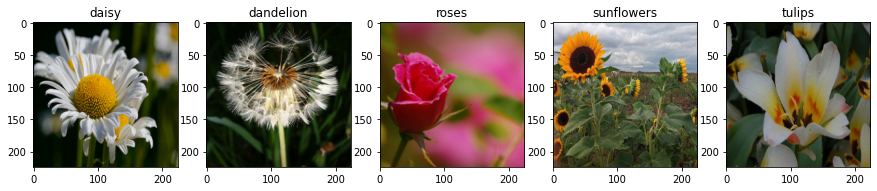

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
  "gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://cloud-ml-data/img/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://cloud-ml-data/img/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://cloud-ml-data/img/flower_photos/tulips/8713398906_28e59a225a_n.jpg"
]):
  img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(CLASS_NAMES[idx])

## A simple rule-based model

Let's get the average color of RGB values in the different
types of flowers and then classify an unknown image as
belonging to closest centroid.

In [ ]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
  # label = tf.math.equal(CLASS_NAMES, label_string)
  return img, label_string

dataset = (tf.data.TextLineDataset(
    "gs://cloud-ml-data/img/flower_photos/train_set.csv").
    map(decode_csv))

for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1]) # average pixel in the image
  print(label, avg)

tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32)


This will take a while if we do all the images,
since there are about 800 images
per type of flower. Later in the book, we will look at
ways to speed up full passes through the data.

In [ ]:
class Centroid:
  def __init__(self, label):
    self.label = label
    self.sum_so_far = tf.constant(0., dtype=tf.float32)
    self.count_so_far = 0
  
  def update(self, value):
    self.sum_so_far = self.sum_so_far + value
    self.count_so_far = self.count_so_far + 1
    if self.count_so_far%100 == 0:
      print(self.label, self.count_so_far)

  def centroid(self):
    return self.sum_so_far / self.count_so_far

  def __str__(self):
    return '{} {}'.format(self.label, self.centroid().numpy())


class CentroidRule:
  def __init__(self):
    self.centroids = {
        f: Centroid(f) for f in CLASS_NAMES}

  def fit(self, dataset):
    for img, label in dataset:
      label = label.numpy().decode("utf-8")
      avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
      self.centroids[label].update(avg)
  
  def predict(self, img):
    avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
    best_label = ""
    best_diff = 999
    for key, val in self.centroids.items():
      diff = tf.reduce_sum(tf.abs(avg - val.centroid()))
      if diff < best_diff:
        best_diff = best_diff
        best_label = key
    return best_label
  
  def evaluate(self, dataset):
    num_correct, total_images = 0, 0
    for img, label in dataset:
      correct = label.numpy().decode('utf-8')
      predicted = self.predict(img)
      if correct == predicted:
        num_correct = num_correct + 1
      total_images = total_images + 1
    accuracy = num_correct / total_images
    return(accuracy)

In [ ]:
rule = CentroidRule()

# to try it on the full dataset, remove the .take(500)
train_dataset = (tf.data.TextLineDataset(
    "gs://cloud-ml-data/img/flower_photos/train_set.csv").
    map(decode_csv)).take(500)

eval_dataset = (tf.data.TextLineDataset(
    "gs://cloud-ml-data/img/flower_photos/eval_set.csv").
    map(decode_csv)).take(50)

rule.fit(train_dataset)

# There is not much separation between the classes
print(rule.centroids['daisy'])
print(rule.centroids['roses'])

# let's evaluate it
rule.evaluate(eval_dataset)

dandelion 100
tulips 100
daisy [0.44554377 0.44968474 0.3594977 ]
roses [0.46776444 0.37675467 0.31471127]


0.24

That's pretty much a random guess!!

In [ ]:
# this is how you'd use the model to predict
filename = "gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg"
img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
pred = rule.predict(img)
print(pred)

tulips


## A linear model
What if you apply different weights each of the pixels?
Let's use the Keras API

In [ ]:
# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

train_dataset = (tf.data.TextLineDataset(
    "gs://cloud-ml-data/img/flower_photos/train_set.csv").
    map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "gs://cloud-ml-data/img/flower_photos/eval_set.csv").
    map(decode_csv)).batch(10)

# linear model
model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)),
              tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


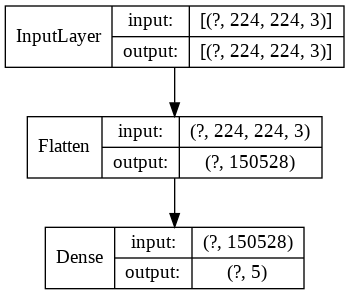

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
330/330 [==============================] - 415s 1s/step - loss: 15.1259 - accuracy: 0.3439 - val_loss: 17.2507 - val_accuracy: 0.3243
Epoch 2/10
330/330 [==============================] - 78s 237ms/step - loss: 15.3072 - accuracy: 0.4261 - val_loss: 29.8571 - val_accuracy: 0.4081
Epoch 3/10
330/330 [==============================] - 79s 240ms/step - loss: 15.0276 - accuracy: 0.4473 - val_loss: 32.3636 - val_accuracy: 0.3757
Epoch 4/10
330/330 [==============================] - 79s 239ms/step - loss: 13.5027 - accuracy: 0.4842 - val_loss: 20.9574 - val_accuracy: 0.4649
Epoch 5/10
330/330 [==============================] - 79s 240ms/step - loss: 11.7072 - accuracy: 0.5233 - val_loss: 19.5944 - val_accuracy: 0.4162
Epoch 6/10
330/330 [==============================] - 80s 241ms/step - loss: 13.2798 - accuracy: 0.5279 - val_loss: 22.5345 - val_accuracy: 0.4027
Epoch 7/10
330/330 [==============================] - 79s 240ms/step - loss: 12.8077 - accuracy: 0.5430 - val_loss: 15.8

In [ ]:
history.history.keys()
def training_plot(metric, history):
  plt.plot(history.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.plot(history.history['val_' + metric], ls='dashed');
  plt.legend([metric, 'val_' + metric])

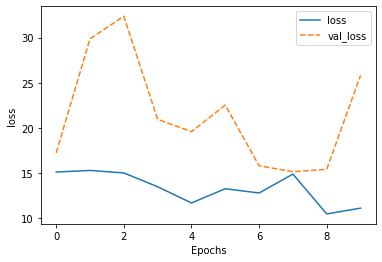

In [ ]:
training_plot('loss', history);

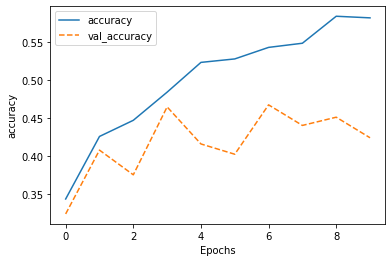

In [ ]:
training_plot('accuracy', history)

[0.09405971 0.0570501  0.8488902 ]
[0.04838872 0.07218749 0.8794238 ]


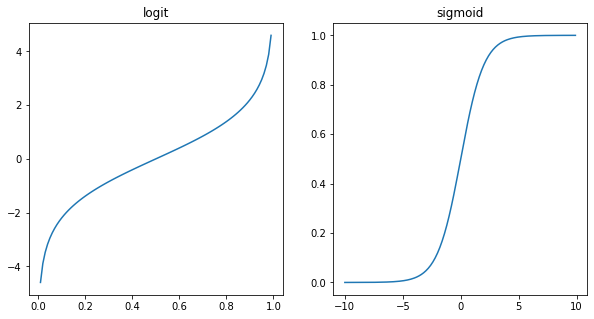

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y);
ax[1].set_title("sigmoid")

print( tf.math.softmax([-1.0, -1.5, 1.2]).numpy() )
print( tf.math.softmax([0.1, 0.5, 3.0]).numpy() )

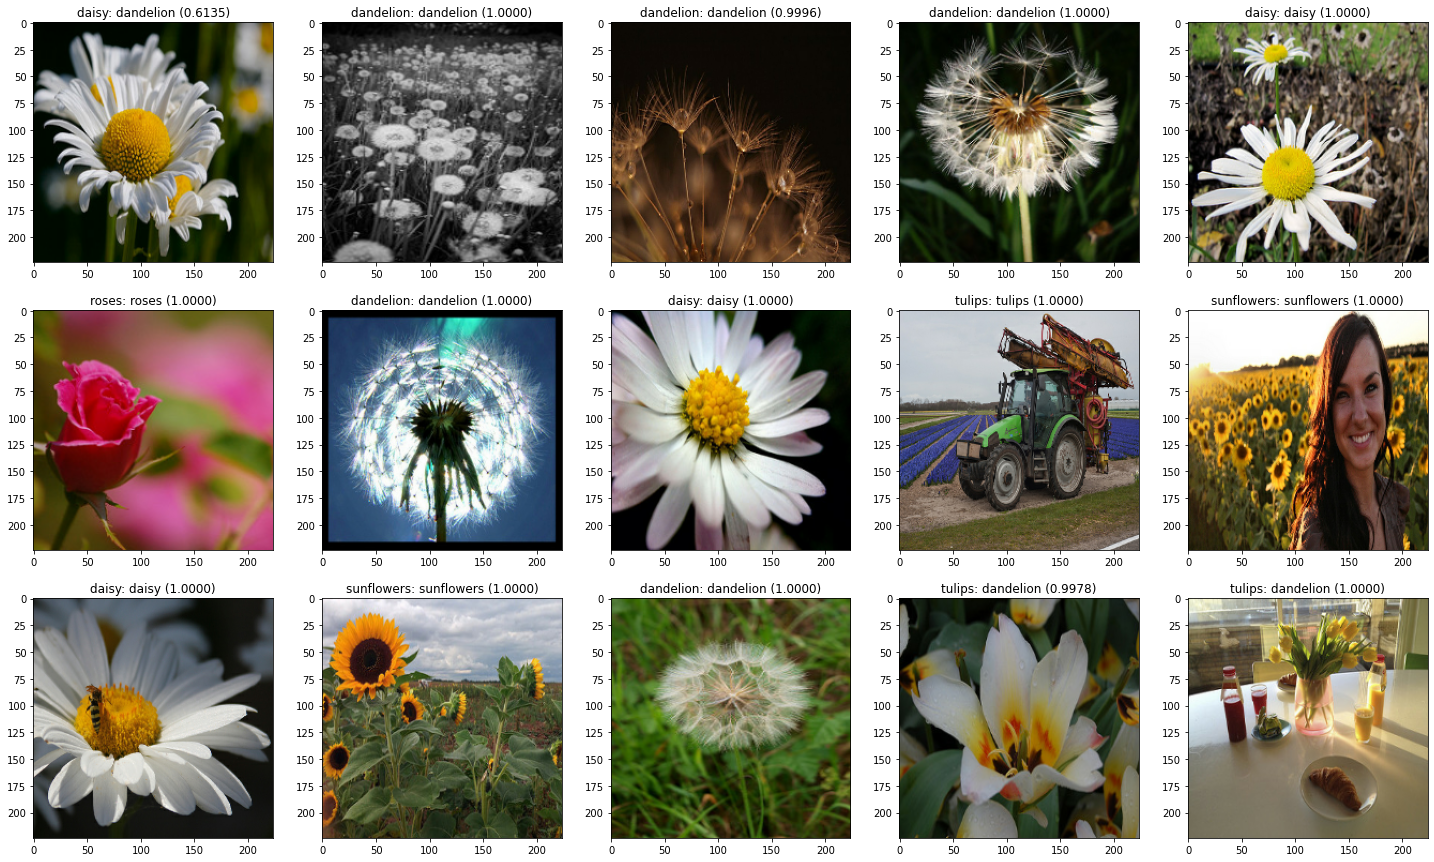

In [ ]:
# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

plot_predictions("gs://cloud-ml-data/img/flower_photos/train_set.csv")

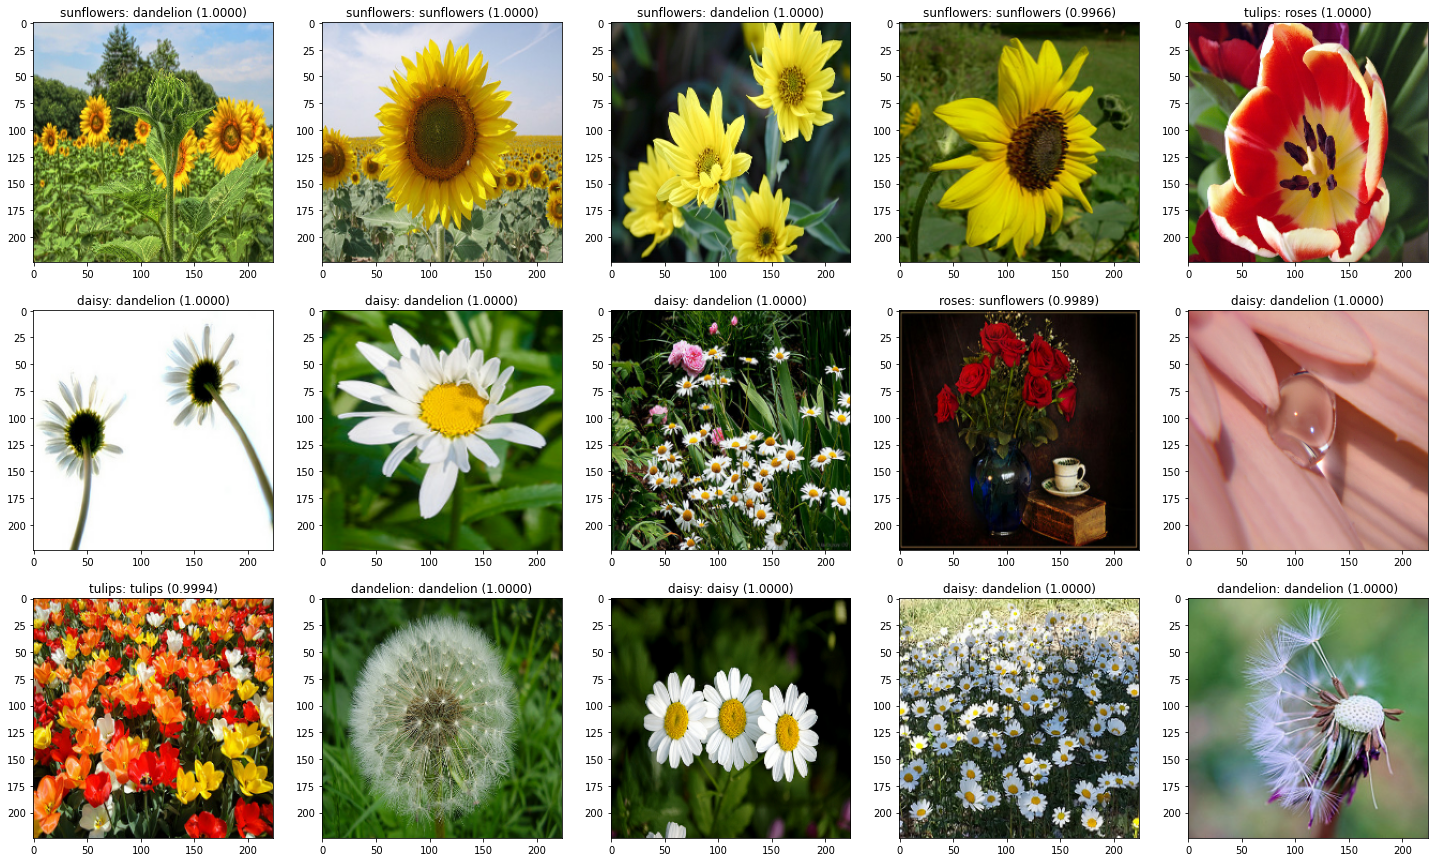

In [ ]:
plot_predictions("gs://cloud-ml-data/img/flower_photos/eval_set.csv")

Scaling weights for daisy in -0.1400132030248642 to 0.11755678057670593
Scaling weights for dandelion in -0.1194157525897026 to 0.1433272659778595
Scaling weights for roses in -0.11747615039348602 to 0.12644261121749878
Scaling weights for sunflowers in -0.14917171001434326 to 0.12388180941343307
Scaling weights for tulips in -0.11622291058301926 to 0.11004119366407394


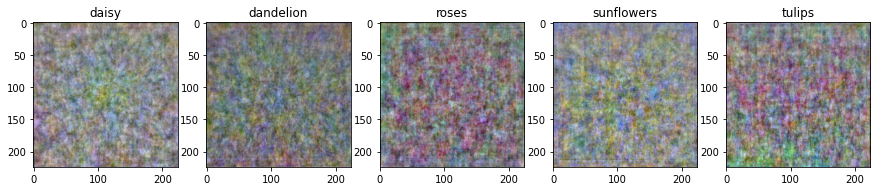

In [ ]:
def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_WIDTH, IMG_HEIGHT, 3));
    ax[flower].set_title(flower_name);

show_trained_weights(model)

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.